In [1]:
###### Package installations to work on WIRE

! pip install mamba
! pip install pysankey
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['gensim', 'openai']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?

In [6]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import openai
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
import sknetwork as skn
from random import *

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

In [4]:
def get_clusters(trdf):
    #keyword frequency
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
    freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='Sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    freq = freq_df.to_numpy()
    for i in range(sent.shape[0]):
        for j in range(sent.shape[1]):
            if freq[i][j] < 2:
                sent[i][j] = 0
    

    #get program simmilarities by topic
    program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    c = 0
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(1 - abs(sp[w] - sp1[w]) / 2)
            if len(p_p1) > 0:
                psim.append(sum(p_p1) / len(p_p1))
            else:
                psim.append(0)
                c += 1
            #print(len(p_p1))
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()
    print(c)
    
    #program_sim_network = np.multiply(program_topic_network, program_sent_network)
    program_sim_network = program_topic_network * program_sent_network

    
    
    network_embedding = SpectralEmbedding(affinity='precomputed')
    pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.show()
    #network_embedding = SpectralEmbedding(affinity='precomputed')
    #pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    
    #clustering
    clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network)
    clust_df = pd.DataFrame(list(zip(progs, list(clustering.labels_))),
               columns =['Program', 'Cluster'])
    return clust_df

214


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


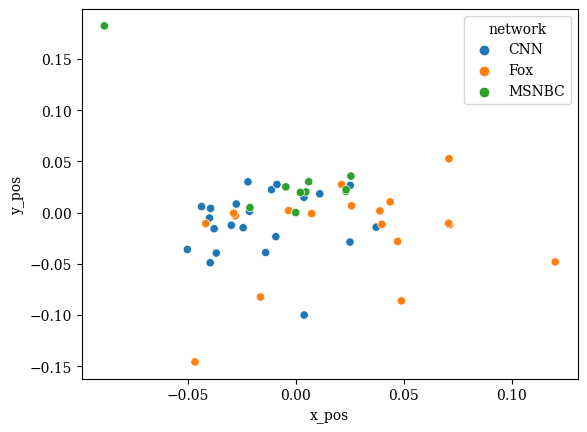

115


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


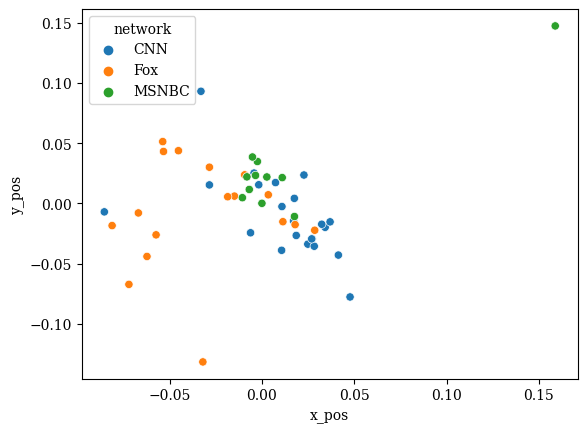

202


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


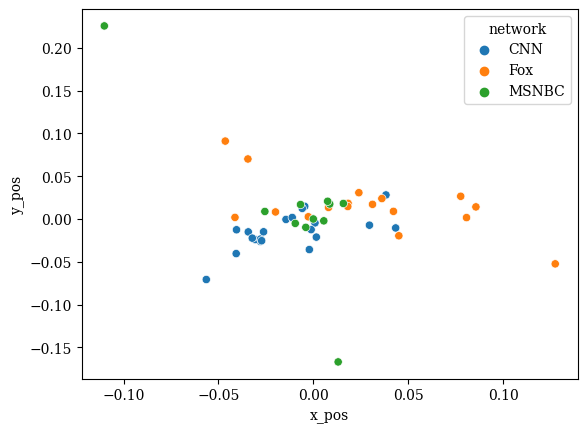

269


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


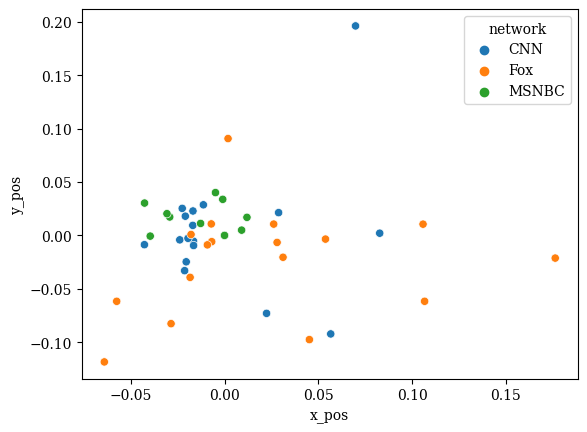

87


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


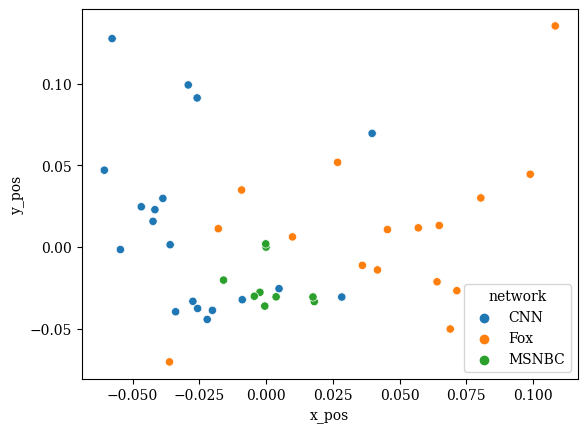

444


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


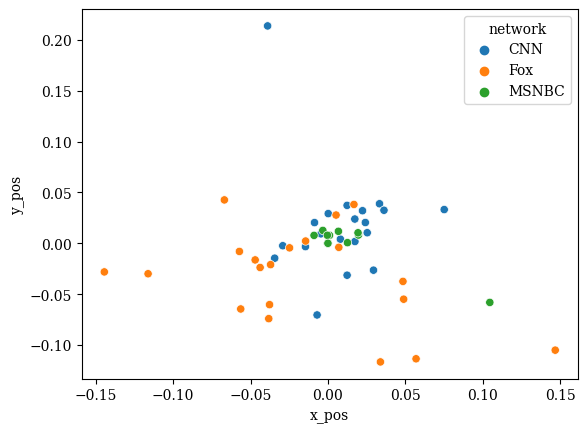

309


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


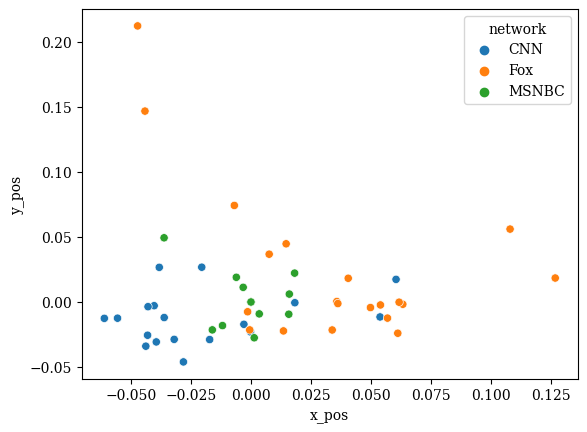

236


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


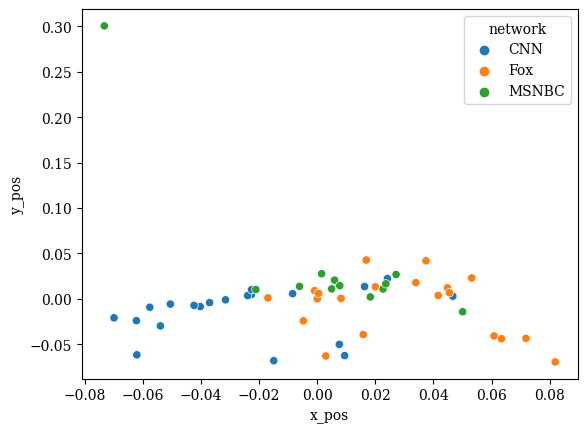

371


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


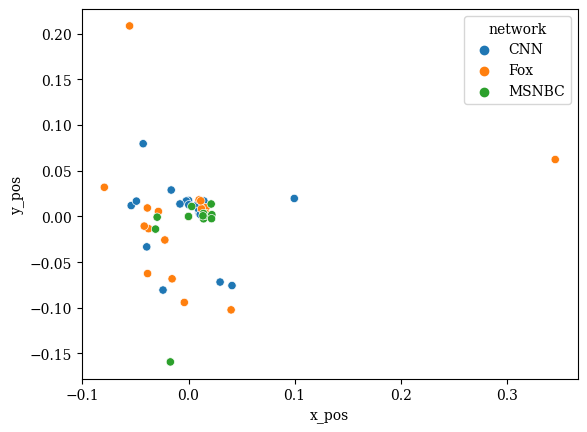

313


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


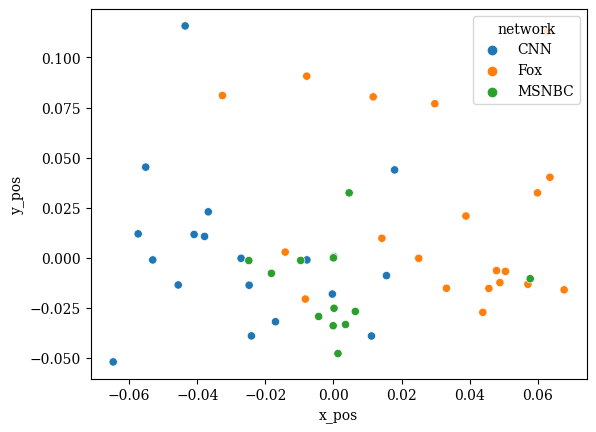

238


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


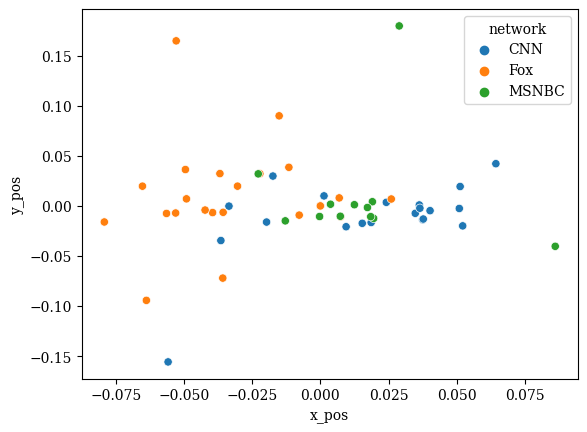

124


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


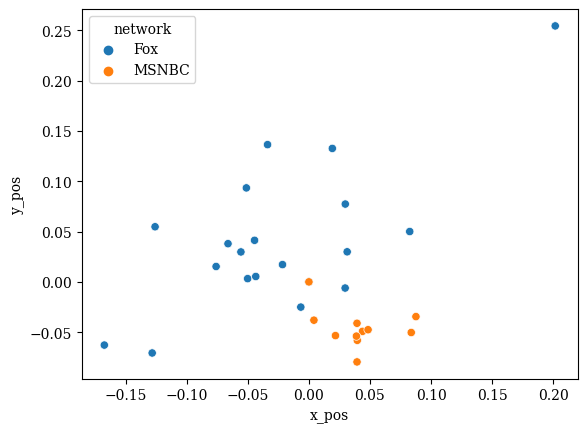

In [21]:
data = ['processed_transcripts_January2020.csv','processed_transcripts_February2020.csv',
        'processed_transcripts_March2020.csv','processed_transcripts_April2020.csv', 'processed_transcripts_May2020.csv','processed_transcripts_June2020.csv',
       'processed_transcripts_July2020.csv','processed_transcripts_August2020.csv','processed_transcripts_September2020.csv','processed_transcripts_October2020.csv',
       'processed_transcripts_November2020.csv','processed_transcripts_December2020.csv']
for i in range(len(data)):
    trdf = pd.read_csv(data[i])
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
clusters_df.to_csv('clustersdf.csv')

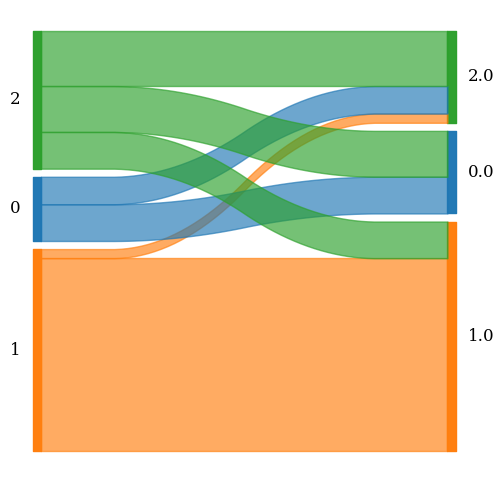

In [9]:
#print(clusters_df)
sankey_df = clusters_df.dropna()
#print(sankey_df)

from pySankey.sankey import sankey

pd.options.display.max_rows = 8

colorDict = {
    0:'#1f77b4',
    1:'#ff7f0e',
    2:'#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    5: '#8c564b',
    6: '#f3f71b',
}
sankey(
    sankey_df['Cluster_0'],sankey_df['Cluster_1'], aspect=20, colorDict=colorDict,
    fontsize=12
)

In [19]:
sankey_df.to_csv('sankey_data.csv')

In [18]:
import plotly.graph_objects as go



fig = go.FigureWidget(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "A3","B1", "B2", "B3","C1", "C2","C3"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'FigureWidget'

In [17]:
import pandas as pd
from floweaver import *
sankey_df['Count'] = 1
flows = (
    sankey_df.groupby(["Cluster_0", "Cluster_1", "Cluster_2","Cluster_3"])
    .agg({"Count": "count"})
    .dropna()
    .reset_index()
    .rename(
        columns={
            "Cluster_0": "source",
            "Cluster_1": "type",
            #"Cluster_2": "March",
            "Cluster_3": "target",
            "Count": "value",
        }
    )
)
print(flows)

# 1. Define a new waypoint node
nodes = {
    "January": ProcessGroup(sankey_df['Cluster_0'].unique().tolist()),
    "April":ProcessGroup(sankey_df['Cluster_3'].unique().tolist()),
}
nodes["February"] = Waypoint(sankey_df['Cluster_1'])
#nodes["March"] = Waypoint(sankey_df['Cluster_2'])

# 2. Update the ordering to show where the waypoint goes: in the middle
ordering = [
    ["January"],
    ["February"],
    #["March"],
    ["April"],
]

embark_port = Partition.Simple("process", flows["source"].unique().tolist())
disembark_port = Partition.Simple("process", flows["target"].unique().tolist())
cruise_region = Partition.Simple("type", flows.type.unique())

nodes["January"].partition = embark_port
nodes["April"].partition = disembark_port
nodes["February"].partition = cruise_region

# 3. Update the bundle definition to send the flows via the waypoint
bundles = [
    Bundle("January", "April", waypoints=["February"]),
]

# Update the SDD with the new nodes, ordering & bundles.
sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows, link_color=QuantitativeScale("value", palette='Blues_9')).to_widget().auto_save_png(
    "waypoint.png"
)

    source  type  Cluster_2  target  value
0        0   0.0        2.0     0.0      4
1        0   2.0        1.0     1.0      1
2        0   2.0        2.0     0.0      2
3        1   1.0        0.0     0.0      3
..     ...   ...        ...     ...    ...
8        2   1.0        0.0     0.0      2
9        2   1.0        0.0     1.0      2
10       2   2.0        0.0     0.0      3
11       2   2.0        2.0     0.0      3

[12 rows x 5 columns]


/tmp/ipykernel_9157/1686510773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sankey_df['Count'] = 1


SankeyWidget(groups=[{'id': 'January', 'type': 'process', 'title': '', 'nodes': ['January^0', 'January^1', 'Ja…